In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = ['3459', '2748', '9268']
should_save_fig = True

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_test = lob.load_prepared_data(
        s, data_dir='../data/prepared', length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
print('Dates of datasets')
for s in stocks:
    print(s)
    print('training', min(d_stocks[s].index), '-', max(d_stocks[s].index))
    print('testing', min(d_test_stocks[s].index), '-', max(d_test_stocks[s].index))

Dates of datasets
3459
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00
2748
training 2013-09-02 08:30:00 - 2013-10-30 12:51:00
testing 2013-10-30 12:52:00 - 2013-11-14 10:10:00
9268
training 2013-09-02 08:30:00 - 2013-10-30 12:47:00
testing 2013-10-30 12:48:00 - 2013-11-14 10:06:00


## Logistic regression on queue imbalance feature


In [5]:
from sklearn import utils
def get_classes_weights(df):
    y_train = df['mid_price_indicator'].values
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

In [6]:
def get_scores_dict_for_data(functions_to_run, dfs, clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = LogisticRegression(random_state=0, class_weight=get_classes_weights(d_stocks[stock])) #21312)
    res_train = model.validate_model(log_clf, d_stocks[stock][['queue_imbalance']], 
                         d_stocks[stock]['mid_price_indicator'])
    dfs = {'test': d_test_stocks[stock]}
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    d_stocks[stock]['pred_log'] = log_clf.predict(d_stocks[stock][['queue_imbalance']])

    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [7]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
3459,0.344387,0.092428,0.120196,0.236054,0.641646,0.576229,3459,0.352005,0.112207,0.130774,...,0.129963,0.250888,0.600319,0.581691,"[0.36654569449026725, 0.371033360455655, 0.361...","[0.11206933746230985, 0.11422034093170752, 0.1...","[0.1383540326726628, 0.14171977601535152, 0.14...","[0.2584321935333799, 0.2612282309807516, 0.257...","[0.6301758366420873, 0.6400898371701291, 0.605...","[0.5861307221130574, 0.5879020614422075, 0.588..."
2748,0.275834,0.115930,0.143627,0.234475,0.496546,0.592444,2748,0.291378,0.090305,0.134270,...,0.105855,0.184566,0.580131,0.575097,"[0.26843878697117185, 0.2090909090909091, 0.22...","[0.06169525741580861, 0.09248273018217901, 0.0...","[0.08403748562839436, 0.0973096088719295, 0.10...","[0.17552019583843328, 0.1644993498049415, 0.17...","[0.5704057279236276, 0.2868480725623583, 0.352...","[0.5597074167202498, 0.5615038526779661, 0.571..."
9268,0.429318,0.109560,0.116182,0.354562,0.544722,0.563328,9268,0.455886,0.122201,0.132175,...,0.122804,0.366101,0.564870,0.566503,"[0.46559538524927896, 0.44929889298892983, 0.4...","[0.1203107617434479, 0.12525541618276848, 0.12...","[0.13132272935561157, 0.13319997013049167, 0.1...","[0.3744201457919152, 0.3700461949914904, 0.362...","[0.6154684095860566, 0.5717505634861006, 0.531...","[0.5705879981274781, 0.572202182617205, 0.5686..."


In [8]:
df_scores[['train_matthews', 'matthews', 'test_matthews']]

,train_matthews,matthews,test_matthews
3459,0.129963,0.120196,0.130774
2748,0.105855,0.143627,0.134270
9268,0.122804,0.116182,0.132175


In [9]:
print('log')
df_scores[['train_roc_auc', 'roc_auc', 'test_roc_auc']]

log


,train_roc_auc,roc_auc,test_roc_auc
3459,0.581691,0.576229,0.581522
2748,0.575097,0.592444,0.596587
9268,0.566503,0.563328,0.571607


In [10]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 'train_roc_auc', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &  matthews &  test\_matthews &  train\_roc\_auc &   roc\_auc &  test\_roc\_auc \\
\midrule
3459 &        0.129963 &  0.120196 &       0.130774 &       0.581691 &  0.576229 &      0.581522 \\
2748 &        0.105855 &  0.143627 &       0.134270 &       0.575097 &  0.592444 &      0.596587 \\
9268 &        0.122804 &  0.116182 &       0.132175 &       0.566503 &  0.563328 &      0.571607 \\
\bottomrule
\end{tabular}



In [11]:
df_scores.to_csv('res_overview_all_three_logistic_regression.csv')

In [12]:
print(df_scores[['f1', 'test_f1_score', 'precision', 'test_precision', 'recall', 'test_recall']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        f1 &  test\_f1\_score &  precision &  test\_precision &    recall &  test\_recall \\
\midrule
3459 &  0.344387 &       0.352005 &   0.236054 &        0.256027 &  0.641646 &     0.563097 \\
2748 &  0.275834 &       0.291378 &   0.234475 &        0.184830 &  0.496546 &     0.687964 \\
9268 &  0.429318 &       0.455886 &   0.354562 &        0.368774 &  0.544722 &     0.596883 \\
\bottomrule
\end{tabular}



Saving figure


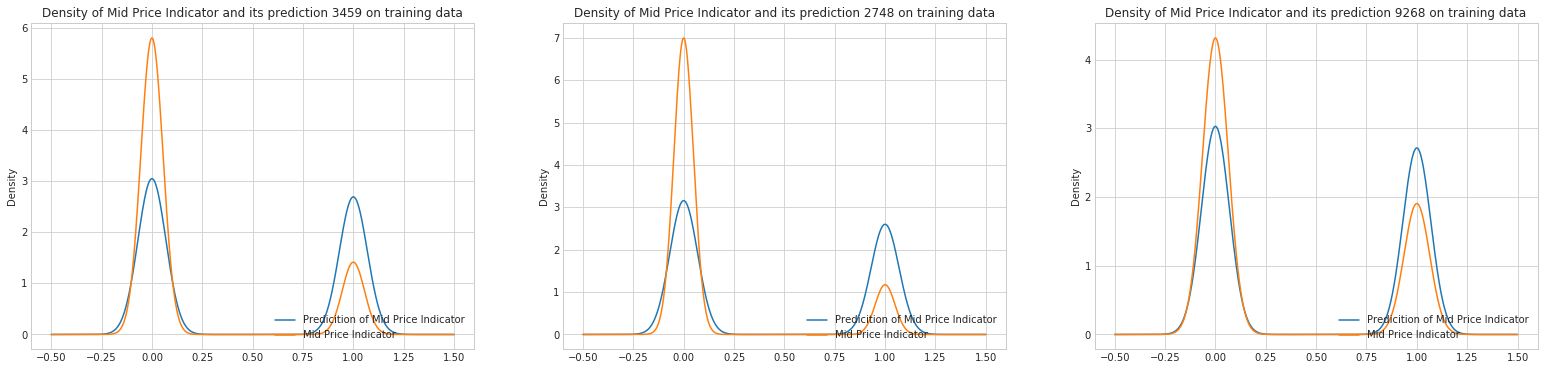

In [13]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    d_stocks[stock][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(stock))
    ax[i].legend(loc='lower right')
if should_save_fig:
    print('Saving figure')
    plt.savefig('density_of_mid_price_and_prediction_training_data.png')

Saving figure


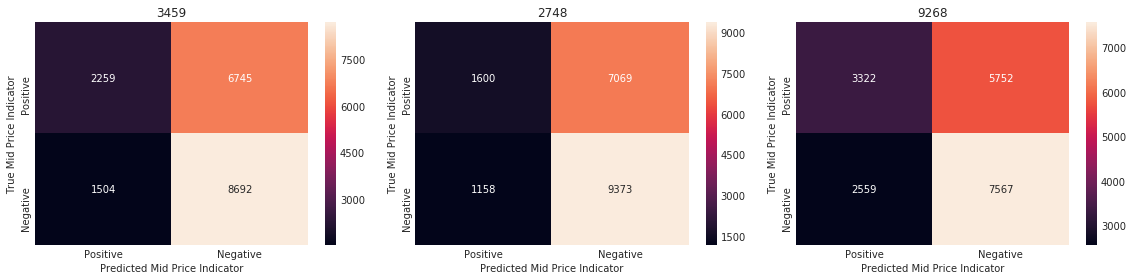

In [14]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    tn, fp, fn, tp = metrics.confusion_matrix(d_stocks[stock]['mid_price_indicator'], 
                                                  d_stocks[stock]['pred_log']).ravel()
    sns.heatmap([[tp, fp], [fn, tn]],
               ax=ax[i], annot=True, fmt='d', xticklabels=['Positive', 'Negative'], 
                yticklabels=['Positive', 'Negative'])
    
    ax[i].set_title('{}'.format(stock))
    ax[i].set_ylabel('True Mid Price Indicator')
    ax[i].set_xlabel('Predicted Mid Price Indicator')
plt.tight_layout()
if should_save_fig:
    print('Saving figure')
    plt.savefig('logistic_confusion_matrix.png')

In [15]:
pivots = []
print('Pivot values')
for i in df_scores.index:
    stock = i
    df = d_stocks[stock]
    
    pivot = np.mean([np.min(df[df['pred_log'] == 1]['queue_imbalance']), 
                    np.max(df[df['pred_log'] == 0]['queue_imbalance'])])
    pivots.append(pivot)
df_scores['pivot'] = pivots
df_scores[['pivot', 'stock']]

Pivot values


,pivot,stock
3459,0.096860,3459
2748,0.038263,2748
9268,0.018577,9268


In [16]:
for k, d in d_stocks.items():
    above_pivot = []
    pivot = df_scores[df_scores['stock'] == k]['pivot'].values[0]
    for i, row in d.iterrows():
        if row['queue_imbalance'] < pivot:
            above_pivot.append(0)
        else:
            above_pivot.append(1)
    d['above_pivot'] = above_pivot

Text(0.5,1,'Positive and ')

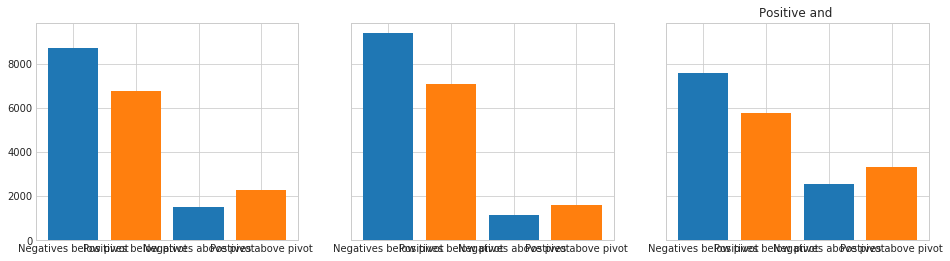

In [17]:
f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 4))
i = 0

for k, d in d_stocks.items():
    pivot = df_scores[df_scores['stock'] == k]['pivot'].values[0]
    df = d[d['queue_imbalance'] < pivot]
    confusion_matrix1 = metrics.confusion_matrix(df['mid_price_indicator'], df['pred_log'])
    ax[i].bar(height = confusion_matrix1.ravel(), x=['Negatives below pivot','Positives below pivot',
                                                     'Negatives above pivot','Postives above pivot'])
    df = d[d['queue_imbalance'] > pivot]
    confusion_matrix2 = metrics.confusion_matrix(df['mid_price_indicator'], df['pred_log'])
    ax[i].bar(height = confusion_matrix2.ravel(), x=['Negatives below pivot','Positives below pivot',
                                                     'Negatives above pivot','Postives above pivot'])
    i += 1
plt.title('Positive and ')

AttributeError: module 'seaborn' has no attribute 'boxenplot'

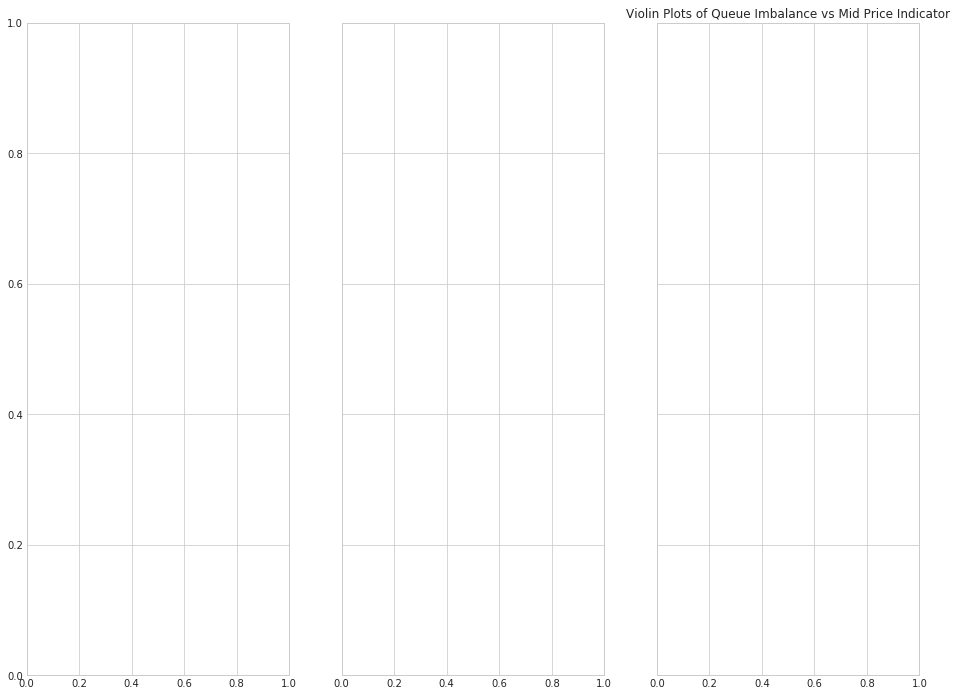

In [18]:
f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 12))
plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')
i = 0
for k, d in d_stocks.items():
    pivot = df_scores[df_scores['stock'] == k]['pivot'].values[0]
    df = d[d['queue_imbalance'] < pivot]
    sns.boxenplot(y=df['queue_imbalance'], x=df['mid_price_indicator'], ax=ax[i], palette='Set2',)
    df = d[d['queue_imbalance'] > pivot]
    sns.boxenplot(y=df['queue_imbalance'], x=df['mid_price_indicator'], ax=ax[i], palette='Set1', )
    ax[i].set_title(k)
    ax[i].set_ylabel('Queue Imbalance')
    ax[i].set_xlabel('Mid Price Indicator')
    i += 1

plt.ylabel('Queue Imbalance')
plt.xlabel('Mid Price Indicator')

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    X = df[['queue_imbalance']].values
    y = df['mid_price_indicator'].values.astype(np.integer)
    
    clf = LogisticRegression(class_weight=get_classes_weights(df))
    clf.fit(X, y)
    plot_decision_regions(X[0:1000], y[0:1000], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('Logistic Regression Decision Regions for {} on training data'.format(stock))
    ax[i].set_xlim(-1.01, 1.01)
plt.tight_layout()
if should_save_fig:
    print('Saving figure')
    plt.savefig('logistic_regression_decision_region.png'.format(s))